In [1]:
import xgboost

print(xgboost.__version__)

3.1.1


In [ ]:
# XGboost -> 파이썬 래퍼, 사이킷런 래퍼 두가지 사용가능

# eta(learning_rate): 학습률.
# num_boost_round(n_estimators): 부스팅 반복 횟수.
# gamma(min_split_loss): 리프 노드를 추가적으로 분할할지를 결정하는 최소 손실 감소 값. 클수록 보수적인 모델이
# 됩니다.
# max_depth: 트리의 최대 깊이.
# subsample: 각 트리를 학습할 때 사용할 데이터 "샘플의 비율"
# [중요]colsample_bytree: 각 트리를 학습할 때 사용할 "피처의 비율"
# lambda(reg_lambda): L2 규제(Regularization) 파라미터.
# alpha(reg_alpha): L1 규제 파라미터.

In [ ]:
# 부스팅계열이 다갖는 장점 --> 조기종료
# 오차나오기 위해선 --> validation data , learning data
# 사이키럿기반  = 사이킷기반에 있는 함수 다 이용 할수 있다
    # - 사이키럿이 편함

In [6]:
# 파이썬 랩퍼 기반으로 유방암 분류 예측
import xgboost as xgb
from xgboost import plot_importance # 그려주는넘 
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


In [8]:
# 데이터 로딩, 분리

dataset = load_breast_cancer()
X_features = dataset.data # 전체 데이터
y_label = dataset.target  # 전체 레이블

# 데이터프레임
cancer_df = pd.DataFrame(
    data = X_features,
    columns = dataset.feature_names,
)
cancer_df['target'] = y_label
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [ ]:
# 이데이터 셋은 혹이 있는 데이터, 
# 악성과 양성으로 나눔
# 0 -> 악성, 1 ->양성

In [ ]:
print(dataset.target_names)
# malignanat :  0 -> 악성
# benign : 1 -->양성(음성X)

print(cancer_df['target'].value_counts()) #병원데이터를 다룰땐 불균형이 많다.


['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [22]:
# 데이터와 테이블 분리
X_features = cancer_df.iloc[:,:-1] #target 제외
y_label = cancer_df.iloc[:,-1]#레이블만 추출

#학습 /테스트 데이터 분리 : 8:2
X_train, X_test, y_train, y_test = train_test_split(
    X_features,
    y_label,
    test_size = 0.2,
    random_state = 156
)

# 학습/검증 데이터 분리 : 9:1 
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train,y_train, test_size = 0.1, random_state=156
)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape) # shape 하면 nadaraty기반이다

(455, 30) (114, 30)
(409, 30) (46, 30)


In [26]:
# 파이썬 래퍼 기반 XGBoost 는 ndarray 바로 사용못한다 -> DMatrix() 변환
# 1.학습/레이블 변환
dtr = xgb.DMatrix(data = X_tr, label =y_tr) # 좀더 빠르것으로 예상함

# 2.검증/레이블 벼 ㄴ환
dval = xgb.DMatrix(data=X_val, label=y_val)

#3. 테스트/레이블 변환
dtest = xgb.DMatrix(data=X_test,label=y_test)

In [35]:
# 파라미터 -> 딕셔너리로 저장->나중에 해짐
params = {
    'max_depth':3,
    'eta':0.01,    #학습률 
    'objective' :'binary:logistic',  #이진분류 하겠다 ,어떻게 학습학지 분류하는 모델, 
    'eval_metric':'logloss', # 오차에 로그 합성 -> 평가해서 -> early 핮ㄹ미말지 경ㄹ저\
                             # 평가지표 : 로그오차함수
}
num_rounds = 1000 # 트리갯수 따로주는 이유 , C 처럼 코딩

# 검증 데이터 지정
eval_list = [(dval,'eval')] # dval은 우리가만든 변수라 문자열 처리 X

In [ ]:
# 학습 
# 파이썬기반에서는 피팅을 하면 모델이 만들어진다.
xgb_model = xgb.train(
    params = params,
    dtrain=dtr, #학습에 사용할 데이터 셋 지정
    num_boost_round=num_rounds,
    
    #early stopping 주는 이유 -> 조기종료
    early_stopping_rounds = 50,#50(patience): 참을횟수
    evals = eval_list
)

[0]	eval-logloss:0.65350
[1]	eval-logloss:0.64766
[2]	eval-logloss:0.64218
[3]	eval-logloss:0.63682
[4]	eval-logloss:0.63133
[5]	eval-logloss:0.62619
[6]	eval-logloss:0.62116
[7]	eval-logloss:0.61598
[8]	eval-logloss:0.61116
[9]	eval-logloss:0.60618
[10]	eval-logloss:0.60155
[11]	eval-logloss:0.59700
[12]	eval-logloss:0.59246
[13]	eval-logloss:0.58786
[14]	eval-logloss:0.58358
[15]	eval-logloss:0.57938
[16]	eval-logloss:0.57532
[17]	eval-logloss:0.57105
[18]	eval-logloss:0.56715
[19]	eval-logloss:0.56283
[20]	eval-logloss:0.55859
[21]	eval-logloss:0.55442
[22]	eval-logloss:0.55032
[23]	eval-logloss:0.54629
[24]	eval-logloss:0.54233
[25]	eval-logloss:0.53935
[26]	eval-logloss:0.53536
[27]	eval-logloss:0.53159
[28]	eval-logloss:0.52773
[29]	eval-logloss:0.52380
[30]	eval-logloss:0.51983
[31]	eval-logloss:0.51603
[32]	eval-logloss:0.51219
[33]	eval-logloss:0.50851
[34]	eval-logloss:0.50479
[35]	eval-logloss:0.50123
[36]	eval-logloss:0.49748
[37]	eval-logloss:0.49394
[38]	eval-logloss:0.49

In [39]:
# (일반화)성능 평가: X_test , y_test => dtest

pred_probs = xgb_model.predict(dtest)
print(np.round(pred_probs[:10],3))  # 예측확률이 표현되는데 한쪽만 나온다.

# 결과: 1일 확률

[0.883 0.018 0.721 0.096 0.96  0.991 0.991 0.988 0.989 0.011]


In [ ]:
preds = [1 if x > 0.5 else 0 for x in pred_probs ]
print(preds[:10])


[1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [41]:
# 불균형 데이터셋 -> f1score, auc봐야함

from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test,pred,pred_proba):
    confusion = confusion_matrix(y_test,pred)
    accuracy= accuracy_score(y_test, pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    #AUC
    roc_auc = roc_auc_score(y_test,pred_proba)
    print('오차 행렬')
    print(confusion)
    print(f'정확도:{accuracy:.4f}, 정밀도: {precision:.4f} ,재현율 :{recall:.4f}\
        F1 :{f1:.4f} , AUC:{roc_auc:.4f}'
          
          
        )
    
    

In [42]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[36  1]
 [ 2 75]]
정확도:0.9737, 정밀도: 0.9868 ,재현율 :0.9740        F1 :0.9804 , AUC:0.9961


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

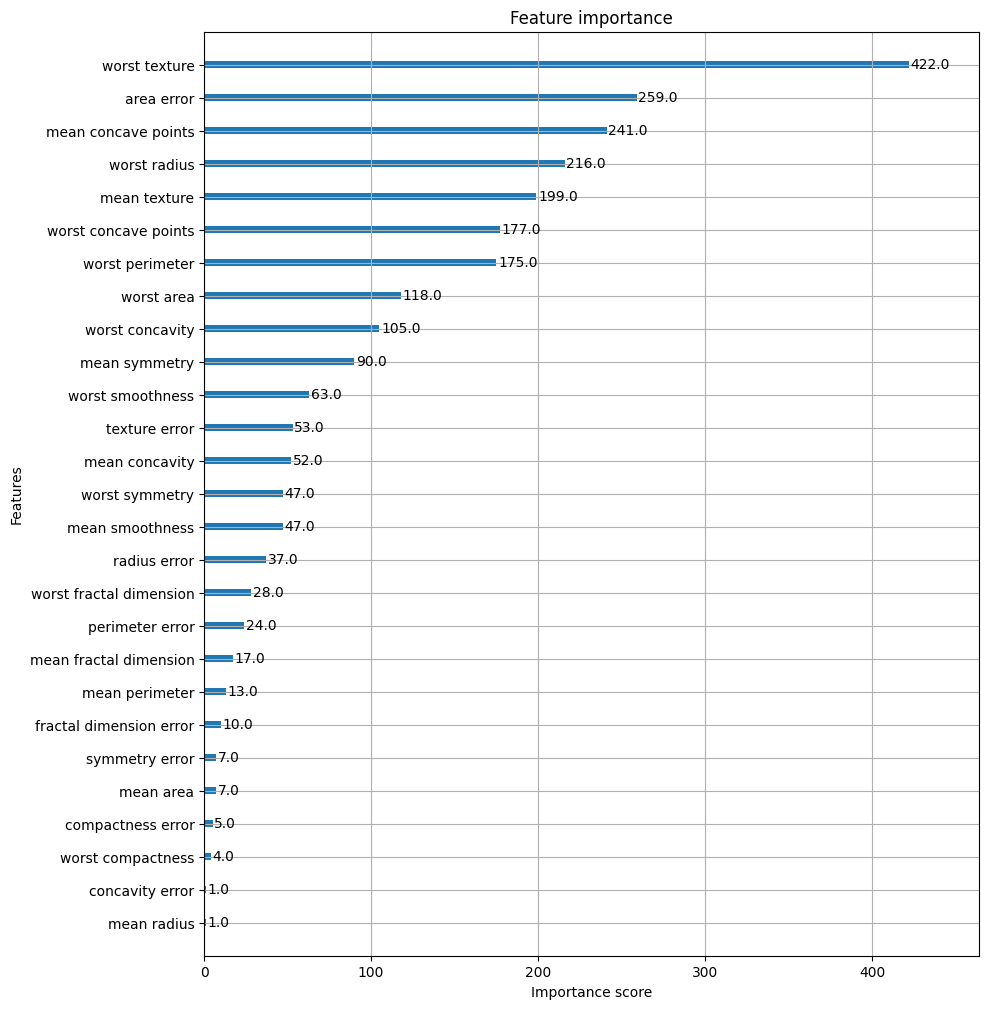

In [44]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

In [48]:
# 사이킷런 기반(간단)
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(n_estimators=500, learning_rate = 0.01, max_depth = 5, random_state = 0)
xgb_clf.fit(X_train, y_train)
preds = xgb_clf.predict(X_test) # 예측값
pred_proba = xgb_clf.predict_proba(X_test)[:,1] # 클래스가 1인 예측 확률 
get_clf_eval(y_test,preds, pred_proba)


오차 행렬
[[35  2]
 [ 3 74]]
정확도:0.9561, 정밀도: 0.9737 ,재현율 :0.9610        F1 :0.9673 , AUC:0.9926


In [ ]:
xgb_clf = XGBClassifier(
    n_estimators = 10000,
    early_stopping_rounds = 100, 
    eval_metric = 'logloss',
    learning_rate = 0.01,
    max_depth = 5
)

evals = [(X_val,y_val)]
xgb_clf.fit(X_tr,y_tr,eval_set =evals,verbose=False) # verbose : 로그 찍지마라~~~


# 결론)XGboost 는 hyperparameter 가 엄청많아서 , 엄청 민감하다
# BGM 보다 따른이유? -> n_job을 안줘서 코어를 풀로 쓴다~~~~

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,100
,enable_categorical,False
,eval_metric,'logloss'


In [68]:
preds_100  = xgb_clf.predict(X_test)
pred_proba_100 = xgb_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test,preds_100, pred_proba_100)


오차 행렬
[[35  2]
 [ 2 75]]
정확도:0.9649, 정밀도: 0.9740 ,재현율 :0.9740        F1 :0.9740 , AUC:0.9947
